# Задание 2: Трехклассовая семантическая сегментация

Предлагается решить задачу семантической сегментации животных с тремя классами: класс "фон" (метка 0), класс "кошка" (метка 1) и класс "собака" (метка 2).
![Image](https://miro.medium.com/max/1130/1*DDEkOFC93pEbrTdyhdpXZg.png)

Для этого сами подготовим [датасет](https://drive.google.com/uc?export=download&id=1ZsRAXiPgOU5Am8tNZ7mruwtJh3ck8TI5), реализуем метрики/функции потерь, реализуем и обучим свою [PSPNet](https://arxiv.org/abs/1612.01105)-подобную архитектуру.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [4]:
import shutil
shutil.rmtree("SegTask", ignore_errors=True)

In [5]:
import zipfile, os
zipfile.ZipFile("/content/drive/MyDrive/cmc2022_SegmentationTask.zip", 'r').extractall()

### Загрузка модулей

In [6]:
# Загружаем pytorch для работы с нейронными сетями
import torch
import torch.nn as nn
import torch.nn.functional as F

# Для работы с изображениями/графиками
from torchvision import transforms
# Загружаем способы интерполяции изображений
from torchvision.transforms.functional import InterpolationMode as IM
import matplotlib.pyplot as plt

# Для логирования метрик и функций потерь в ходе обучения
from torch.utils.tensorboard import SummaryWriter

# Для удобной работы с обучающей/тестовой выборкой
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Прочее
import numpy as np
from tqdm.notebook import tqdm

## Часть 1: Подготовка данных

### 1.1 Предобработка датасета (1 балл)

Для начала работы с данными требуется выполнить следующие пункты:
- Определиться со способом хранения/чтения данных с диска. В задачах комьютерного зрения датасеты, как правило, имеют большой размер, который не помещается в оперативную память. Поэтому предлагается несколько форматов хранения: `HDF5`, `memory-mapped files` и `"сырой"` вид, т.е хранение `.jpg/.png` файлов на диске. Классы с указанными способами уже описаны в файле `utils.py`. Вам предлагается лишь замерить скорость чтения данных для каждого из форматов, затем выбрать наиболее быстрый (чуть позже).
    - Поговорим поподробнее об особенностях этих форматов хранения. Формат `hdf5` позволяет разбивать массивы информации на [chunks](https://www.oreilly.com/library/view/python-and-hdf5/9781491944981/ch04.html), которые организованы в виде B-деревьев. Это имеет смысл при чтении `hyperslabs` - многомерных срезов массива, которые несмежны в памяти (non-contiguous). По умолчанию, `hdf5` хранит данные непрерывно (contiguous)
    - `Memory-mapping` файлов в оперативную память позволяет пропустить этап буфферизации, тем самым пропуская операцию копирования, лениво загружая информацию напрямую. Особенность этого подхода в том, что алгоритмически `Best case` скорости чтения достигается на непрерывном блоке информации (contiguous), а `Worst case` - наоборот, на несмежном в памяти (non-contiguous) блоке (на порядки хуже, чем потенциально возможно в `hdf5`).

- Привести все пары (изображение, маска) к единому размеру `target_shape`, указанному далее в словаре конфигурации `default_config`. Предлагается следующая последовательность действий:
    1. При помощи [transforms.Resize](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) мы можем интерполировать (по умолчанию билинейная интерполяция) значения пикселей при изменении размера исходного изображения до заданного. Однако, подобная операция искажает исходное соотношение сторон изображения, что может негативно сказаться на предсказательной способности сети. Например, общий вид морды кошки будет зависеть от исходного размера изображения, а не от сущности класса "кошка": оно может быть не растянуто, может быть растянуто вертикально/горизонтально. Неконсистентность в представлении одной и той же сущности может привести к нестабильному обучению, так как размеры ядра свертки едины для любого входного изображения! К счастью, эта проблема уже решена в `transforms.Resize`: при целочисленном аргументе `size` наименьшая сторона входного изображения будет интерполирована до `size`, а другая сторона (наибольшая) до размера `size * aspect_ratio`, т.е сохраняя соотношение сторон `aspect_ratio`
    2. На текущий момент лишь одна из сторон исходного изображения соответствует требуемому размеру `target_shape`. Возможны два случая: оставшаяся сторона меньше или больше (случай с равенством можно свести к ситуации "меньше на 0") требуемого размера. В первом случае будем дополнять изображение пикселями со значением `pad_value` при помощи [transforms.Pad](https://pytorch.org/vision/stable/generated/torchvision.transforms.Pad.html#torchvision.transforms.Pad), а во втором - обрезать изображение при помощи [transforms.CenterCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.CenterCrop.html#torchvision.transforms.CenterCrop).

> Последовательное исполнение операций модуля `transforms` можно выполнить при помощи [transforms.Compose](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html).
- Ответить на вопрос: `А зачем, вообще, требуется сводить все изображения к одному размеру?`

Ваш ответ: ...

In [7]:
from utils import *

def resize(img: Image, target_shape: Tuple[int, int], pad_val: int) -> np.array:
    """
    Приводит входное изображение `img` к размеру `target_shape`, указанной выше 
    последовательностью действий. Предполагается, что требуемый размер `target_shape` "квадратный"
    """
    # Проверяем равенство желаемых размеров сторон изображения
    assert target_shape[0] == target_shape[1]
    
    # Необходимо для "универсальности" определения количества недостающих padding-пикселей.
    # В случае если размерность текущего изображения меньше требуемой - имеем неотрицательное
    # Количество недостающих padding-пикселей, relu возвращает это число без изменений.
    # В случае если размерность текущего изображения больше требуемой - имеем отрицательное
    # Количество недостающих padding-пикселей, т.е в padding пикселях мы не нуждаемся и 
    # relu возвращает значение 0.
    def relu(x):
        return x * (x > 0)
    
    # Масштабируем наименьшую размерность `img` под `target_shape`
    # В качестве способа интерполяции выберем интерполяцию методом ближайшего соседа
    # Это необходимо для сохранения множества значений маски сегментации
    img = transforms.Resize((target_shape[0], target_shape[1]), interpolation=IM.NEAREST)(img)

    # Вычисляем количество недостающих padding-пикселей для каждой из сторон изображения
    h, w = img.size[0], img.size[1]
    h_diff, w_diff = target_shape[0] - h, target_shape[1] - w

    pad_left, pad_right = w_diff // 2, w_diff // 2
    pad_top, pad_bottom = h_diff // 2, h_diff // 2
    
    resize_transform = transforms.Compose([
        # Добавляем padding-пиксели. Если их нет, то операция Pad ничего не изменит (случай "больше").
        transforms.Pad(
            (relu(pad_left), relu(pad_top), relu(pad_right), relu(pad_bottom)),
            fill=pad_val, padding_mode="constant"
        ),
        # Обрезаем "лишние" пиксели. Если их нет, то CenterCrop ничего не изменит (случай "меньше").
        transforms.CenterCrop((target_shape[0], target_shape[1])),
        
        # Преобразуем PIL.Image изображение в массив np.array
        transforms.Lambda(lambda x: np.array(x))
    ])

    return resize_transform(img)

In [8]:
def prepare_dataset(config: dict, storage_class: Type[storage_class]):
    """
    Предобрабатывает датасет и эффективно его сохраняет на диск
    """
    with open(config["annotation_file"]) as f:
        lines = f.readlines()
        
    # Заводим массивы для блоков изображений, помещаемых в память
    input_chunk = np.empty((config["chunk_size"], *config["target_shape"], 3), dtype=np.uint8)
    target_chunk = np.empty((config["chunk_size"], *config["target_shape"]), dtype=np.uint8)
    
    # Делим датасет на блоки
    config["dataset_size"] = len(lines)
    num_chunks = config["dataset_size"] // config["chunk_size"] + bool(config["dataset_size"] % config["chunk_size"])
    dataset = storage_class(config)
    
    # Читаем изображения с диска, предобрабатываем и сохраняем в выбранный нами формат
    for chunk_idx in tqdm(range(num_chunks)):
        for pos in range(config["chunk_size"]):
            flat_idx = chunk_idx * config["chunk_size"] + pos
            if (flat_idx >= config["dataset_size"]):
                break
                                 
            img_name, label = lines[flat_idx].rstrip("\n").split(' ')
                              
            input_raw = Image.open(os.path.join(config["input_dir"], img_name + ".jpg")).convert("RGB")
            target_raw = Image.open(os.path.join(config["target_dir"], img_name + ".png")).convert('L')

            input_chunk[pos] = resize(input_raw, config["target_shape"], 0)
            target_chunk[pos] = renumerate_target(resize(target_raw, config["target_shape"], 2), int(label))
        dataset.append(input_chunk, target_chunk)
    dataset.lock()
    
    return dataset

Для простоты будем выбирать размер изображений `target_shape` с одинаковыми сторонами. Предлагается использовать размер `256x256`, хотя выбор за вами. Обратите внимание, что от размера изображений зависит быстродействие дальнейшего кода (чем больше картинки, тем дольше обучать).

In [9]:
# Конфигурация датасета
default_config = {
             "input_dir": "SegTask/images",
             "target_dir": "SegTask/seg_masks",
             "target_shape": (256, 256), # Можно любой другой размер картинки
             "chunk_size": 512, # количество изображений в блоке, загружаемых в оперативную память
            }

# Конфигурации обучающей и тестовой выборок отличаются файлов аннотации
config_train = {"annotation_file": "SegTask/trainval.txt"}
config_test = {"annotation_file": "SegTask/test.txt"}
config_train.update(default_config)
config_test.update(default_config)

train_data_hdf5 = prepare_dataset(config_train, storage_hdf5)
train_data_memmap = prepare_dataset(config_train, storage_memmap)
train_data_raw = prepare_dataset(config_train, storage_raw)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

### 1.2 Создание Dataset и DataLoader (1.5 балла)

Pytorch [предоставляет](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) нам удобные обертки Dataset и DataLoader для наших данных, которые эффективно нарезают наш датасет на `batches` (блоки) заданного размера, а также параллелизуют процесс чтения на `num_workers` нитей.

Также для дальнейшей работы нам понадобится [аугментация](https://pytorch.org/vision/stable/transforms.html) данных. Ее цель заключается в еще большем расширении обучающей выборки путем применения преобразований над изображениями, которые изменяют их абсолютные значения пикселей, но не нарушают их информационное наполнение.

Например, преобразование [ColorJitter](https://pytorch.org/vision/stable/generated/torchvision.transforms.ColorJitter.html#torchvision.transforms.ColorJitter) способно изменить яркость изображения на случайное число, что не изменяет его контекст. Однако, преобразование  [RandomCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomCrop.html#torchvision.transforms.RandomCrop) не рекомендуется, посколько есть шанс, что мордочка животного не попадет в фото и класс животного будет неоднозначен. Таким образом, при каждом вызове объекта из обучающей выборки к нему будет применяться случайное преобразование/серия случайных преобразований. `Обратите внимание, что преобразование изображения должно быть согласованным с его сегментационной маской`.

Требуется реализовать предлагаемые ниже преобразования аугментации:
- `HorizontalFlip` (0.25 балла)
- `ColorJitter` (0.25 балла)
- `RandomPerspective` (0.5 балла)

Для каждого из указанных преобразований требуется написать магический метод `__call__`, который позволяет обращаться к объекту класса (преобразованию), как к функции (функтор из C++):
```Python
# инициализация
obj = Example()
# вызывается __call__
obj()
```

In [10]:
# Предлагается использовать эти функции
# Самому писать процедуры отражения картинки по вертикали/горизонтали или цветокоррекции не надо!
from torchvision.transforms.functional import hflip
from torchvision.transforms.functional import perspective
from torchvision.transforms import ColorJitter as CJ


class HorizontalFlip():
    def __init__(self, prob: float):
        self.p = prob

    def __call__(self, pair: Tuple[Image.Image, Image.Image]) -> Tuple[Image.Image, Image.Image]:
        """
        `pair` содержит пару (изображение, сегментационная маска)
        """
        if np.random.binomial(1, self.p):
          pair = (hflip(pair[0]), hflip(pair[1]))
        
        return pair

    
class ColorJitter():
    def __init__(self, prob: float, param: Tuple[float]):
        self.p = prob
        self.parameters = param

    def __call__(self, pair: Tuple[Image.Image, Image.Image]) -> Tuple[Image.Image, Image.Image]:
        """
        `pair` содержит пару (изображение, сегментационная маска)
        """
        bright, contr, satur = self.parameters
        change_color = CJ(brightness=bright, contrast=contr, saturation=satur)
        if np.random.binomial(1, self.p):
          pair = (change_color(pair[0]), pair[1])
        
        return pair


class RandomPerspective():
    def __init__(self, prob: float, param: float):
        self.p = prob
        self.parameter = param

    def __call__(self, pair: Tuple[Image.Image, Image.Image]) -> Tuple[Image.Image, Image.Image]:
        """
        `pair` содержит пару (изображение, сегментационная маска)
        """
        height = default_config["target_shape"][0]
        width = default_config["target_shape"][0]
        
        half_height = height // 2
        half_width = width // 2
        topleft = [
            int(torch.randint(0, int(self.parameter * half_width) + 1, size=(1,)).item()),
            int(torch.randint(0, int(self.parameter * half_height) + 1, size=(1,)).item()),
        ]
        topright = [
            int(torch.randint(width - int(self.parameter * half_width) - 1, width, size=(1,)).item()),
            int(torch.randint(0, int(self.parameter * half_height) + 1, size=(1,)).item()),
        ]
        botright = [
            int(torch.randint(width - int(self.parameter * half_width) - 1, width, size=(1,)).item()),
            int(torch.randint(height - int(self.parameter * half_height) - 1, height, size=(1,)).item()),
        ]
        botleft = [
            int(torch.randint(0, int(self.parameter * half_width) + 1, size=(1,)).item()),
            int(torch.randint(height - int(self.parameter * half_height) - 1, height, size=(1,)).item()),
        ]
        startpoints = [[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]]
        endpoints = [topleft, topright, botright, botleft]
        
        if np.random.binomial(1, self.p):
          pair = (perspective(pair[0], startpoints, endpoints), perspective(pair[1], startpoints, endpoints, IM.NEAREST))
        
        return pair

Применим реализованные преобразования и убедимся в их работоспособности:

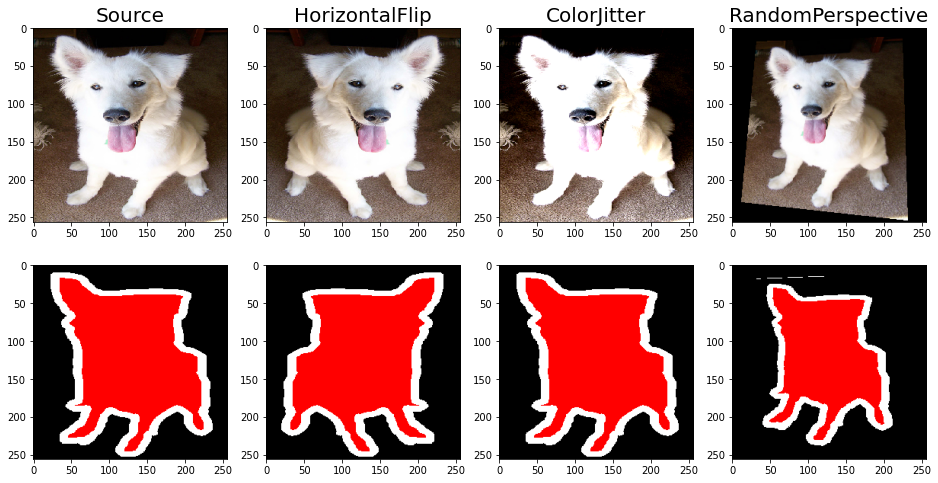

In [11]:
img_idx = np.random.randint(0, 100)
f, ax = plt.subplots(2, 4, figsize=(16, 8))
pair = train_data_hdf5[img_idx]

imgs2draw = {"Source": pair,
            "HorizontalFlip": HorizontalFlip(1.0)(pair),
            "ColorJitter": ColorJitter(1.0, (0.4, 0.4, 0.4))(pair),
            "RandomPerspective": RandomPerspective(1.0, 0.25)(pair)
}
for idx, (name, pair) in enumerate(imgs2draw.items()):
    ax[0, idx].imshow(pair[0])
    ax[0, idx].set_title(name, fontsize=20)
    ax[1, idx].imshow(colorize(np.array(pair[1])))

plt.show()

Далее описываем наш класс `SegmentationData` и операции приведения изображений типа PIL.Image к pytorch тензорам с ImageNet `нормализацией`. ImageNet нормализация - это частный случай [Standard normalization](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html), в котором поканальное среднее (цветовые каналы red, green, blue) и поканальное среднеквадратическое отклонение вычислены на [огромной выборке изображений](https://en.wikipedia.org/wiki/ImageNet).

Ответьте на вопрос: `А для чего нужно применять нормализацию к изображениям?`

Ваш ответ: ...

In [12]:
# Определяем устройство для вычислений (!желательно GPU!)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

t_dict = {
    "forward_input": transforms.Compose([
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: x.float().to(DEVICE)/255.0),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]),
    "backward_input": transforms.Compose([
        transforms.Normalize(mean=[0.0, 0.0, 0.0],
                                     std=[1./0.229, 1./0.224, 1./0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                     std=[1.0, 1.0, 1.0]),
        transforms.Lambda(lambda x: x.permute(1, 2, 0).cpu().numpy())
    ]),
    "forward_target": transforms.Compose([
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: x.long().squeeze().to(DEVICE)),
    ]),
    "backward_target": transforms.Compose([
        transforms.Lambda(lambda x: x.cpu().numpy())
    ]),
    "augment": transforms.Compose([
        HorizontalFlip(0.5),
        ColorJitter(0.5, (0.4, 0.4, 0.4)),
        RandomPerspective(0.5, 0.25)
    ]),
}


class SegmentationDataset(Dataset):
    def __init__(self, dataset_raw: Type[storage_class], transforms: dict, train_flag: bool = True):
        """
        Наследуем весь функционал из `Dataset` для наших данных `dataset_raw`
        `transforms` содержит преобразования PIL.Image <-> torch.tensor и аугментации
        `train_flag` регулирует аугментацию данных (для тестовой выборки она не нужна)
        """
        super().__init__()
        self.dataset_raw = dataset_raw
        self.transforms = transforms
        self.train_flag = train_flag

    def __len__(self):
        return self.dataset_raw.dataset_size
    
    def __getitem__(self, idx: int) -> Tuple[Image.Image, Image.Image]:
        input, target = self.dataset_raw[idx]
        
        if (self.train_flag):
            input, target = self.transforms["augment"]((input, target))
            
        return self.transforms["forward_input"](input), self.transforms["forward_target"](target)

In [13]:
from torch.utils.data import random_split

# Разделяем обучающую выборку на обучающую и валидационную
def split_train_val(train_data: Type[storage_class], train_portion: float = 0.8):
    """
    `train_data` предобработанные данные
    `train_portion` доля объектов, которая будет приходиться на обучающую выборку
    """
    trainval_dataset = SegmentationDataset(train_data, t_dict, train_flag=True)
    
    train_size = int(len(trainval_dataset) * train_portion)
    val_size = len(trainval_dataset) - train_size
    return random_split(trainval_dataset, [train_size, val_size])

train_dataset_hdf5, val_dataset_hdf5 = split_train_val(train_data_hdf5)
train_dataset_memmap, val_dataset_memmap = split_train_val(train_data_memmap)
train_dataset_raw, val_dataset_raw = split_train_val(train_data_raw)

Отрисуем случайное изображение (после применения случайных преобразований аугментации):

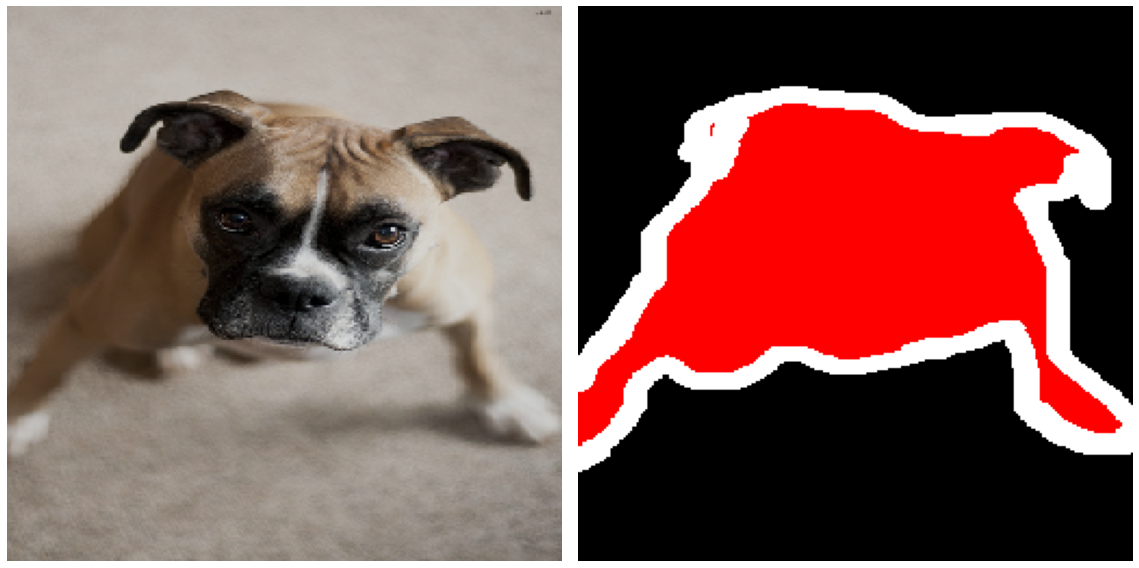

In [14]:
img_idx = np.random.randint(0, 100)
draw(train_dataset_hdf5[img_idx], t_dict);

In [15]:
dataloader_config = {
    "batch_size": 16, # Ваше значение
    "shuffle": True,
    "num_workers": 0
}
train_dataloader_hdf5 = DataLoader(train_dataset_hdf5, **dataloader_config)
val_dataloader_hdf5 = DataLoader(val_dataset_hdf5, **dataloader_config)

train_dataloader_memmap = DataLoader(train_dataset_memmap, **dataloader_config)
val_dataloader_memmap = DataLoader(val_dataset_memmap, **dataloader_config)

train_dataloader_raw = DataLoader(train_dataset_raw, **dataloader_config)
val_dataloader_raw = DataLoader(val_dataset_raw, **dataloader_config)

### 1.3 Замер скорости чтения датасета с диска (0.5 балла)

Замерьте время чтения нашего датасета для каждого из форматов хранения:

In [16]:
def speedtest(dataloader: Type[DataLoader]) -> None:
    for batch in dataloader:
        pass

In [80]:
%timeit speedtest(train_dataloader_hdf5)

17.6 s ± 159 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [81]:
%timeit speedtest(train_dataloader_memmap)

15.4 s ± 211 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
%timeit speedtest(train_dataloader_raw)

24.4 s ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ответьте на вопрос: `Какой формат оказался самым эффективным по скорости? Почему?`

Ваш ответ: Самым эффективным способом хранения оказался формат memmap. Очень близко к нему находится hdf5. 

Создайте тестовый Dataloader победившего по скорости формата.

In [17]:
dataloader_config_test = {
    "batch_size": 16, # Ваше значение
    "shuffle": False,
    "num_workers": 0
}

test_data = prepare_dataset(config_test, storage_memmap)

test_data_segm = SegmentationDataset(test_data, t_dict, train_flag=False)

test_dataloader = DataLoader(test_data_segm, **dataloader_config_test)

  0%|          | 0/8 [00:00<?, ?it/s]

## Часть 2: Реализация функций потерь, метрик и декодировщика PSPNet

Ранее вас познакомили с архитектурой Unet - сверточными автокодировщиком, применяемом в области сегментации изображений. В данном задании мы разберем более продвинутую архитектуру сети сегментации [PSPNet](https://arxiv.org/abs/1612.01105). Отличительной особенностью этой сети является `Pyramid Pooling Module`, который, в отличие от Unet, позволяет учитывать `глобальный` контекст изображения при формировании признаков его `локальных` областей.

Рассмотрим предлагаемую архитектуру `PSPNet-подобной сети`:
![Image](Architecture.svg)

В качестве кодировщика `Encoder` будем брать предобученную [ResNeXt](https://pytorch.org/hub/pytorch_vision_resnext/) сеть. Будем его использовать для получения двух глубинных представлений нашего входого изображения `x`: 
- выход `x_main` - "среднее" промежуточное представление, компромисс между низкоуровневыми признаками (цвет, контуры объектов, штрихи) и высокоуровневыми признаками (абстрактные признаки, отражающие семантику изображения)
- выход `x_supp` - финальное представление, содержащее самые высокоуровневые признаки, в которых значительно утеряна информация о точном простанственном расположении объектов

Подобное разбиение выхода на 2 потока объясняется необходимостью в закодированной информации о пространственном расположении объектов (`x_main`) и вспомогательной информации о семантике всего изображения в целом (`x_supp`) для задачи семантической сегментации. Мы не можем себе позволить использовать лишь выход `x_supp`, как это делается, например, в задачах классификации, ведь от нас требуется дополнительное знание о расположении этого объекта на изображении.

Ваша задача состоит в написании декодировщика `Decoder`, а именно в написании блоков:
- `Pyramid Pooling Module`. К входному тензору `x_main` параллельно применяется несколько операций пулинга разных размеров, которые сводят пространственные размерности исходного тензора до размеров `1x1`, `2x2`, `3x3` и `6x6`. Каналы промежуточных тензоров эффективно редуцируются (при помощи `nn.Conv2d c размером фильтра 1x1`), а затем пространственные размерности интерполируются до исходных размеров. Эта процедура необходима для извлечения глобального контекста разных масштабов, которого не хватает классическим сверточным нейронным сетям (локальный контекст в пределах размера фильтра). Таким образом, выходной тензор, полученный конкатенацией этих глобальных контекстов, содержит информацию о всем входном тензоре с разными уровнями детализации. Промежуточное редуцирование каналов тензоров производится для сжатия информации, а также для индивидуального взвешивания глобального контекста каждого масштаба. Требуется реализовать `forward` этап этого блока. Для уточнения информации можно обратиться к [статье](https://arxiv.org/abs/1612.01105).
- `Supplementary Module` осуществляет нелинейное преобразование над входным тензором `x_supp` с понижением числа каналов до размерности выхода модуля `Pyramid Pooling Module`. Вариант архитектуры этого преобразования (композиции слоев) уже предложен, но, при желании, вы можете с ним экспериментировать
- `Upsample Module` осуществляет нелинейные преобразования над входным тензором с понижением числа каналов, которые чередуются с интерполяцией пространственных размерностей в 2 раза (увеличение). Таким образом, выход этого блока имеет ту же пространственную размерность, что и входное в кодировщик изображение. Это преобразование (слои `Layer 0`, `Layer 1` и `Layer 2`) требуется экспериментально подобрать
- `Segmentation Head` нелинейно преобразует входной тензор в тензор score'ов. Имеем, что выходной тензор для каждого пикселя имеет `num_classes` score'ов (в нашем случае 3). В дальнейшем, индекс максимального score'а для заданного пикселя и будет его меткой класса (0, 1 или 2). Это преобразование (композиция слоев) требуется экспериментально подобрать

Если декодировщик получается слишком тяжелый, то оператор `Concat` можно заменить на поканальное суммирование. Обратите внимание, что нет единственной правильной архитектуры указанных выше блоков. Требуется ее экспериментально подобрать так, чтобы получить наилучшее качество сегментации за разумную сложность.

### 2.1 Кодировщик и декодировщик PSPNet-подобной сети (2.5 балла)

In [34]:
from torchvision.models.resnet import ResNet

pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)

# Выставляем evaluation mode (влияет на поведение таких слоев как BatchNorm2d, Dropout)
pretrained_model.eval();

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Так как кодировщик используется предобученный, то требуется зафиксировать (заморозить) веса, чтобы по ним не тек градиент. Этим мы гарантируем, что кодировщик не изменяется в ходе обучения автокодировщика, а также экономим вычислительные ресурсы (граф градиента кодировщика не строится).

In [35]:
class EncoderBlock(nn.Module):
    def __init__(self, pretrained_model: Type[ResNet]):
        """
        Извлекает предобученные именованные слои кодировщика `pretrained_model`
        Разделяет слои на `main` и `supp` потоки (см. архитектуру выше)
        
        Вход: тензор (Batch_size, 3, Height, Width)
        
        Выход: x_main тензор (Batch_size, 512, Height // 8, Width // 8)
        Выход: x_supp тензор (Batch_size, 2048, Height // 32, Width // 32)
        """
        super().__init__()

        self.encoder_main = nn.Sequential()
        for name, child in list(pretrained_model.named_children())[:-4]:
            print(f"Pretrained main module {name} is loaded")
            self.encoder_main.add_module(name, child)
            
        self.encoder_supp = nn.Sequential()
        for name, child in list(pretrained_model.named_children())[-4:-2]:
            print(f"Pretrained supp module {name} is loaded")
            self.encoder_supp.add_module(name, child)
            
    def freeze(self) -> None:
        """
        Замораживает веса кодировщика
        """
        for p in self.parameters():
            p.requires_grad = False
        self.eval()
            
    def unfreeze(self) -> None:
        """
        Размораживает веса кодировщика
        """
        for p in self.parameters():
            p.requires_grad = True
        self.train()
            
    def forward(self, x: torch.tensor) -> Tuple[torch.tensor, torch.tensor]:
        x_main = self.encoder_main(x)
        x_supp = self.encoder_supp(x_main)
        return x_main, x_supp

In [36]:
encoder = EncoderBlock(pretrained_model)

Pretrained main module conv1 is loaded
Pretrained main module bn1 is loaded
Pretrained main module relu is loaded
Pretrained main module maxpool is loaded
Pretrained main module layer1 is loaded
Pretrained main module layer2 is loaded
Pretrained supp module layer3 is loaded
Pretrained supp module layer4 is loaded


Для оценки сложности модели нам понадобится функция подсчета числа ее параметров, для этого используйте метод `.parameters()`. Реализуйте ее ниже:

Также полезно было бы убедиться, что метод `.parameters()` возвращает то, что мы от него ожидаем. Для этого воспользуемся методом `.named_parameters()`:

In [37]:
for name, parameter in encoder.named_parameters():
    print(name)

encoder_main.conv1.weight
encoder_main.bn1.weight
encoder_main.bn1.bias
encoder_main.layer1.0.conv1.weight
encoder_main.layer1.0.bn1.weight
encoder_main.layer1.0.bn1.bias
encoder_main.layer1.0.conv2.weight
encoder_main.layer1.0.bn2.weight
encoder_main.layer1.0.bn2.bias
encoder_main.layer1.0.conv3.weight
encoder_main.layer1.0.bn3.weight
encoder_main.layer1.0.bn3.bias
encoder_main.layer1.0.downsample.0.weight
encoder_main.layer1.0.downsample.1.weight
encoder_main.layer1.0.downsample.1.bias
encoder_main.layer1.1.conv1.weight
encoder_main.layer1.1.bn1.weight
encoder_main.layer1.1.bn1.bias
encoder_main.layer1.1.conv2.weight
encoder_main.layer1.1.bn2.weight
encoder_main.layer1.1.bn2.bias
encoder_main.layer1.1.conv3.weight
encoder_main.layer1.1.bn3.weight
encoder_main.layer1.1.bn3.bias
encoder_main.layer1.2.conv1.weight
encoder_main.layer1.2.bn1.weight
encoder_main.layer1.2.bn1.bias
encoder_main.layer1.2.conv2.weight
encoder_main.layer1.2.bn2.weight
encoder_main.layer1.2.bn2.bias
encoder_main

In [41]:
def count_parameters(model: Type[nn.Module]) -> int:
    """
    Считает число весов в модели `model`, для которых требуется градиент
    """
    total_params = 0
    
    for i in tuple(model.parameters()):
        count = 1
        if i.requires_grad == True:
            # print(i.shape)
            for j in i.shape:
              count *= j
            total_params += count
        
    return total_params

In [42]:
count_parameters(encoder)

22979904

Убедимся, что метод `.freeze()` успешно замораживает веса:

In [43]:
print("Encoder #parameters before freeze():", count_parameters(encoder))
encoder.freeze()
print("Encoder #parameters after freeze():", count_parameters(encoder))

Encoder #parameters before freeze(): 22979904
Encoder #parameters after freeze(): 0


Реализуйте `PyramidPoolingModule`, `Upsample` и `SegmentationHead` (по 0.5 балла), а также заполните пропущенные значения `???` в `UpsampleModule` и `DecoderBlock` (по 0.25 балла). Выбор параметров/архитектуры сети в большей степени зависит от результатов обучения в следующей части задания (так что вы еще вернетесь к этому пункту).

In [44]:
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, bin_sizes: Tuple[int, ...]):
        """
        Вход: тензор (Batch_size, `in_channels`, Height, Width)
        `bin_sizes` - пространственные размерности для каждой пулинг операции
        Пример: bin_sizes = (1, 2, 3, 6).
        
        Выход: тензор (Batch_size, `in_channels` + len(`bin_sizes`) * `out_channels`, Height, Width)
        """
        super().__init__()
        self.bins = []
        
        for bin_size in bin_sizes:
            self.bins.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin_size),
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
            
        self.bins = nn.ModuleList(self.bins)

    def forward(self, x: torch.tensor) -> torch.tensor:
        h, w = x.shape[2:]
        out = []
        
        for i in self.bins:
            '''print(x.shape)
            print("after ", i(x).shape)
            print("after interpolate ", F.interpolate(i(x), size=(h, w)).shape)'''
            out.append(F.interpolate(i(x), (h, w)))
            
            
        
        """
        Осуществите все пулинг-операции с последующим `Upscale`
        Подсказка: используйте torch.functional.interpolate
        ==== YOUR CODE =====
             ¯\_(ツ)_/¯
        """
        return torch.cat([x] + out, dim=1)

    
class SupplementaryModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout: float):
        """
        Вход: тензор (Batch_size, `in_channels`, Height, Width)
        
        Выход: тензор (Batch_size, `out_channels`, Height, Width)
        """
        super().__init__()
        self.suppl = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels // 2),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(in_channels // 2, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.suppl(x)
    
    
class Upsample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.us_transform = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        h, w = x.shape[2:]
        return F.interpolate(self.us_transform(x), (2 * h, 2 * w))
    
    
class UpsampleModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        """
        Вход: тензор (Batch_size, `in_channels`, Height, Width)
        
        Выход: тензор (Batch_size, `out_channels`, 8 * Height, 8 * Width)
        """
        super().__init__()
        self.upsample = nn.Sequential(
            Upsample(in_channels, in_channels // 2),
            Upsample(in_channels // 2, in_channels // 4),
            Upsample(in_channels // 4, out_channels)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.upsample(x)

In [45]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, bin_sizes: Tuple[int, ...], dropout: float = 0.1):
        """
        Вход  x_main: тензор (Batch_size, `in_channels`, Height, Width)
        Вход  x_supp: тензор (Batch_size, 4 * `in_channels`, Height // 4, Width // 4)
        
        Выход: тензор (Batch_size, `out_channels`, 8 * Height, 8 * Width)
        """
        super().__init__()
        assert in_channels % len(bin_sizes) == 0

        self.PPM = PyramidPoolingModule(in_channels, in_channels // 2, bin_sizes)
        self.SM = SupplementaryModule(4 * in_channels, in_channels, dropout)
        self.UM = UpsampleModule(4 * in_channels, out_channels)
        
    def forward(self, x_main: torch.tensor, x_supp: torch.tensor) -> torch.tensor:
        '''print("x_supp ", x_supp.shape)
        print("x_main ", x_main.shape)'''
        
        h_supp, w_supp = x_supp.shape[2:]
        x_supp = F.interpolate(input=x_supp, size=(4 * h_supp, 4 * w_supp), mode='bilinear', align_corners=True)
        
        x_supp = self.SM(x_supp)
        x_main = self.PPM(x_main)
        
        '''print("x_supp after ", x_supp.shape)
        print("x_main after ", x_main.shape)
        print("cat", torch.cat([x_main, x_supp], dim=1).shape)'''
        
        out = self.UM(torch.cat([x_main, x_supp], dim=1))
        return out

    
class SegmentationHead(nn.Module):
    def __init__(self, in_channels: int, num_classes: int, dropout: float):
        """
        Вычисляет score для каждого из классов
        Вход: тензор (Batch_size, `in_channels`, Height, Width)
        
        Выход: тензор (Batch_size, `num_classes`, Height, Width)
        """
        super().__init__()
        self.segmentation_head = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Conv2d(in_channels, num_classes, kernel_size=1)
        )
        '''nn.Conv2d(in_channels, in_channels // 2, kernel_size=1),
            nn.Dropout(p=dropout),
            nn.Conv2d(in_channels // 2, in_channels // 4, kernel_size=1),
            nn.Dropout(p=dropout),
            nn.Conv2d(in_channels // 4, num_classes, kernel_size=1)'''

    def forward(self, x: torch.tensor, x_supp: torch.tensor) -> torch.tensor:
        """
        На будущее зададим фиктивный аргумент `x_supp`, который пока не будем использовать
        """
        return self.segmentation_head(x)

### 2.2 Реализация метрик (3.5 балла)

В задаче сегментации для оценки предсказательной способности нейронной сети, в основном, используют следующие метрики:

Пусть $\mathrm{P}$ обозначает прогноз сег. маски (Prediction), $\mathrm{S}$ обозначает score'ы для каждого класса сег. маски (Scores), а $\mathrm{T}$ означает сег. маску (Target). Тогда:
- Intersection over Union metric (коэффициент Жаккара):
$$
\mathrm{IoU}(P, T) = \dfrac{\sum_{i=1}^{M}\sum_{j=1}^{N}[P_{ij}*T_{ij}]}{\sum_{i=1}^{M}\sum_{j=1}^{N} [P_{ij} + T_{ij} - P_{ij}*T_{ij}]}\text{, где } P, T \in \{0, 1\}^{M \times N}
$$
- Recall metric (полнота):
$$
\mathrm{Recall}(P, T) = \dfrac{\sum_{i=1}^{M}\sum_{j=1}^{N}[P_{ij} * T_{ij}]}{\sum_{i=1}^{M}\sum_{j=1}^{N} T_{ij}}\text{, где } P, T \in \{0, 1\}^{M \times N}
$$
Указанные выше метрики расписаны для случая бинарной сегментации, которая нам не подходит. Обобщим их на случай мультиклассовой сегментации: представим K-классовую задачу как K двухклассовых, а затем `макро-` или `микро-`усредним для них метрики. Требуется реализовать мультиклассовые варианты указанных метрик с поддержкой макро- и микро-усреднения (по 1 баллу). Обратите внимание, что метрики рассчитываются для каждого элемента из батча. За редуцирование метрик вдоль размерности батча отвечает аргумент `reduce` (см. ниже).

Также для обучения будем использовать две разные, но схожие функции потерь:
- Cross Entropy Loss (кросс-энтропия):
$$
\mathrm{CE}(S, T) = - \dfrac{1}{MN}\sum_{c=1}^{K}\sum_{i=1}^{M}\sum_{j=1}^{N} \big[\log \mathrm{Softmax}(S)_{cij}*\mathbb{I}[T_{ij} == c]\big]\text{, где } S \in \mathbb{R}^{K \times M \times N}, T \in \{1, ..., K\}^{M \times N}
$$
- [Focal Loss](https://arxiv.org/abs/1708.02002):
$$
\mathrm{FL}(S, T) = - \dfrac{1}{MN}\sum_{c=1}^{K}\sum_{i=1}^{M}\sum_{j=1}^{N} \big[(1 - \mathrm{Softmax}(S)_{cij})^{\gamma}*\log \mathrm{Softmax}(S)_{cij}*\mathbb{I}[T_{ij} == c]\big]\text{, где } S \in \mathbb{R}^{K \times M \times N}, T \in \{1, ..., K\}^{M \times N}, \gamma \in \mathbb{R}_{+} - \text{гиперпараметр} 
$$

Требуется реализовать обе функции потерь. Также всюду необходимо обеспечить корректную обработку значений `ignore_index`, которые в нашем случае равны 255 (не участвуют в расчете метрик/функций потерь). Если представители некоторых классов в $\mathrm{T}$ отсутствуют, то учитывать эти классы при макро-усреднении не нужно.

In [46]:
class MetricsCollection():
    def __init__(self, num_classes: int, ignore_index: int = 255):
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        
    def IoUMetric(self, prediction: torch.tensor, target: torch.tensor, average: str = "macro", reduce: str = "mean") -> Union[torch.tensor, float]:
        """
        `prediction` предсказанная сегментационная маска размера (Batch_size, Height, Width)
        `target` истинная сегментационная маска размера (Batch_size, Height, Width)
        `average` тип мультклассового усреднения
        `reduce` редукция значений метрики вдоль размерности Batch; None - без редукции
        """
        assert average in ["micro", "macro"]
        assert reduce in ["sum", "mean", "none"]
        
        size = prediction.shape[0]
        
        res_iou = [0.0] * size
        
        

        predict_label = prediction.data.int()
        target = target.data.int()
        for i in range(size):
            res_tp = [0.0] * self.num_classes
            res_denom = [0.0] * self.num_classes
            label = target[i, :, :]
            pred_label = predict_label[i, :, :]
            delit = self.num_classes
            for j in range(self.num_classes):
                pred_cur = (pred_label.view(-1) == j)
                gt_cur = (label.view(-1) == j)
                tp = (pred_cur & gt_cur).sum()
                if tp == 0:
                    delit -= 1
                denom = (pred_cur | gt_cur).sum() - (pred_cur & (label.view(-1) == self.ignore_index)).sum()
                res_tp[j] += tp
                res_denom[j] += denom
                if average == "macro":
                    if res_denom[j] != 0:
                        res_iou[i] += res_tp[j] / (res_denom[j])
            if average == "macro":
                res_iou[i] /= delit
            else:
                res_iou[i] = sum(res_tp) / sum(res_denom)
            
        if reduce == "mean":        
            return sum(res_iou) / size
        elif reduce == "sum":
            return sum(res_iou)
            
    def RecallMetric(self, prediction: torch.tensor, target: torch.tensor, average: str = "macro", reduce: str = "mean") -> Union[torch.tensor, float]:
        """
        `prediction` предсказанная сегментационная маска размера (Batch_size, Height, Width)
        `target` истинная сегментационная маска размера (Batch_size, Height, Width)
        `average` тип мультклассового усреднения
        `reduce` редукция значений метрики вдоль размерности Batch; None - без редукции
        """
        assert average in ["micro", "macro"]
        assert reduce in ["sum", "mean", "none"]
        
        size = prediction.shape[0]
        
        res_recall = [0.0] * size
        

        predict_label = prediction.data.int()
        target = target.data.int()
        for i in range(size):
            res_tp = [0.0] * self.num_classes
            res_denom = [0.0] * self.num_classes
            label = target[i, :, :]
            pred_label = predict_label[i, :, :]
            delit = self.num_classes
            for j in range(self.num_classes):
                pred_cur = (pred_label.view(-1) == j)
                gt_cur = (label.view(-1) == j)
                tp = (pred_cur & gt_cur).sum()
                if tp == 0:
                    delit -= 1
                denom = gt_cur.sum() - (gt_cur & (label.view(-1) == self.ignore_index)).sum()
                res_tp[j] += tp
                res_denom[j] += denom
                if average == "macro":
                    if res_denom[j] != 0:
                        res_recall[i] += res_tp[j] / (res_denom[j])
            if average == "macro":
                res_recall[i] /= delit
            else:
                res_recall[i] = sum(res_tp) / sum(res_denom)
                
            
        if reduce == "mean":        
            return sum(res_recall) / size
        elif reduce == "sum":
            return sum(res_recall)

    
    def FocalLoss(self, scores: torch.tensor, target: torch.tensor, reduce: str = "mean", gamma: float = 1.) -> Union[torch.tensor, float]:
        """
        `scores` score'ы каждого класса сегментационной маски размера (Batch_size, num_classes, Height, Width)
        `target` истинная сегментационная маска размера (Batch_size, Height, Width)
        `reduce` редукция значений функции потерь вдоль размерности Batch; None - без редукции
        """
        assert scores.shape[1] == self.num_classes
        assert reduce in ["sum", "mean", "none"]
        
        ce_loss = F.cross_entropy(scores, target, ignore_index=self.ignore_index, reduction="none")
        coef = (1 - torch.exp(-ce_loss))**gamma
        focal_loss = coef * ce_loss
        norm = (focal_loss.numel() - (target == self.ignore_index).sum())

        if (reduce == "sum"):
            return focal_loss.sum() / norm * scores.shape[0]
        elif (reduce == "mean"):
            return focal_loss.sum() / norm
        else:
            return focal_loss.sum(dim=[1, 2]) / norm * scores.shape[0]

    def CrossEntropyLoss(self, scores: torch.tensor, target: torch.tensor, reduce: str = "mean") -> Union[torch.tensor, float]:
        """
        `scores` score'ы каждого класса сегментационной маски размера (Batch_size, num_classes, Height, Width)
        `target` истинная сегментационная маска размера (Batch_size, Height, Width)
        `reduce` редукция значений функции потерь вдоль размерности Batch; None - без редукции
        """
        assert scores.shape[1] == self.num_classes
        assert reduce in ["sum", "mean", "none"]

        if (reduce == "sum"):
            return F.cross_entropy(scores, target, ignore_index=self.ignore_index, reduction="mean") * scores.shape[0]
        elif (reduce == "mean"):
            return F.cross_entropy(scores, target, ignore_index=self.ignore_index, reduction="mean")
        else:
            return F.cross_entropy(scores, target, ignore_index=self.ignore_index, reduction="none")

    @classmethod
    def ListMetrics(cls):
        return [method for method in dir(cls) if (method.endswith("Metric"))]
    
    @classmethod
    def ListLosses(cls):
        return [method for method in dir(cls) if (method.endswith("Loss"))]

In [47]:
metric_class = MetricsCollection(num_classes=3, ignore_index=255)

prediction = torch.tensor([[[0, 0, 0, 0], [0, 0, 1, 0], [0, 1, 1, 0], [0, 0, 0, 0]],
                           [[0, 0, 0, 0], [0, 2, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]]])

target = torch.tensor([[[0, 0, 0, 0], [0, 1, 255, 0], [0, 1, 255, 0], [0, 0, 0, 0]],
                       [[0, 0, 0, 0], [0, 255, 2, 0], [0, 255, 2, 0], [0, 0, 0, 0]]])


assert np.isclose(metric_class.RecallMetric(prediction, target, "micro", "mean").item(), 0.9286, atol=1e-3)
assert np.isclose(metric_class.RecallMetric(prediction, target, "macro", "mean").item(), 0.7500, atol=1e-3)
assert np.isclose(metric_class.IoUMetric(prediction, target, "micro", "mean").item(), 0.8667, atol=1e-3)
assert np.isclose(metric_class.IoUMetric(prediction, target, "macro", "mean").item(), 0.7115, atol=1e-3)

Ответьте на вопрос (№1): `Что говорит о предсказательной способности нашей сети ситуация: высокий Recall и низкий IoU для некоторого класса? Возможна ли обратная ситуация?`

Ваш ответ: ...

Ответьте на вопрос (№2): `Какой вид усреднения правильней использовать в нашей задаче: макро и микро? Почему?`

Ваш ответ: ...

Ответьте на вопрос (№3): `В чем преимущество Focal Loss перед Cross Entropy Loss? Что контроллирует гиперпараметр 𝛾 в Focal Loss?`

Ваш ответ: ...

## Часть 3: Обучение PSPNet, эксперименты

Теперь осталось лишь собрать все написанное ранее воедино и обучить нашу сеть. Чтобы контроллировать процесс обучения нашей сети, будем вычислять усредненные метрики и функции потерь на валидационной выборке. Для удобства отображения информации воспользуемся инструментом `tensorboard`. Для этого заведем объект класса `SummaryWriter`, который создаст и откроет на запись специальный `event` файл для [tensorboard](https://pytorch.org/docs/stable/tensorboard.html). Для визуализации содержимого вводится команда `tensorboard --logdir=<PATH>` в терминале. Если возникла необходимость в мониториге нескольких tensorboard, то каждому из них требуется присвоить свой уникальный порт `--port <PORT>`. [Пример](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/tensorboard_with_pytorch.ipynb#scrollTo=lFKETpE2F2oE) использования tensorboard на Google Colab.

Требуется написать методы `train_model` и `test_model`. Вся конфигурация обучения хранится в словаре `train_config`. При желании его можно дополнить чем-то своим.

К вашему решению потребуется прикрепить логи tensorboard. Чтобы облегчить процедуру проверки настоятельно рекомендуется пользоваться `inline-tensorboard`:
```
%load_ext tensorboard
%tensorboard --logdir ./runs
```

### 3.1 Реализация процедур обучения/тестирования сети (1 балл)

In [48]:
class PSPNet(nn.Module):
    def __init__(self, pretrained_model: Type[ResNet], HeadBlock: Type[nn.Module], num_classes: int, train_config: dict, bin_sizes: Tuple[int, ...] = (1, 2, 3, 6)):
        """
        `pretrained_model` модель предобученного кодировщика
        `Head` класс блока, оценивающего score'ы для каждого класса сегментационной маски
        `num_class` число классов сегментации
        `train_config` словарь с конфигурацией процесса обучения сети
        `bin_sizes` пространственные размеры к которым сводит пулинг в блоке PPM
        """
        super().__init__()
        self.encoder = EncoderBlock(pretrained_model)
        self.encoder.freeze()
        self.decoder = DecoderBlock(512, 128, bin_sizes)
        self.head = HeadBlock(128, num_classes, 0.5)
        
        self.train_config = train_config
        self.metric_class = train_config["metric_class"]
        self.optimizer = train_config["optimizer"](self.parameters(), **train_config["optimizer_params"])
        self.scheduler = train_config["scheduler"](self.optimizer, **train_config["scheduler_params"])
        
    def forward(self, x: torch.tensor) -> Tuple[torch.tensor, torch.tensor]:
        # Для гарантии отсутствия градиентов по кодировщику
        with torch.no_grad():
            x_main, x_supp = self.encoder(x)
        out = self.decoder(x_main, x_supp)
        out = self.head(out, x_supp)
        return out, torch.argmax(out.detach(), dim=1)
    
    def write_val_metrics(self, val_metrics: dict, iter_num: int, norm: float = 1.0) -> None:
        """
        Записывает усредненные значения метрик/функций потерь в tensorboard
        
        `val_metrics` словарь с ключами "название_метрики/функции потерь" и их значениями
        `iter_num` номер глобальной итерации (по формуле #всего_итераций * номер_эпохи + номер_итерации)
        `norm` фактор нормализации; для усреднения равен числу объектов в валидационной выборке
        """
        for method, value in val_metrics.items():
            self.train_config["writer"].add_scalar(f"Mean {method}", np.round(val_metrics[method].item()/norm, 2), iter_num)
    
    def validate_model(self, val_dataloader: Type[DataLoader], iter_num: int) -> None:
        """
        Валидирует текущую модель и вычисляет соответствующие метрики/функции потерь
        
        `val_dataloader` валидационная выборка
        `iter_num` номер глобальной итерации (по формуле #всего_итераций * номер_эпохи + номер_итерации)
        """
        # Выставляет декодировщик в режим валидации (влияет на поведение BatchNorm2d и Dropout)
        # self.decoder.eval()
        self.eval()
        
        # Инициализация словаря метрик/функций потерь 
        val_metrics = dict([(method, 0.0) for method in (self.metric_class.ListMetrics() + self.metric_class.ListLosses())])
        
        # Обязательно считать с контекстным менеджером torch.no_grad()
        # Даже если мы не делаем шаг оптимизации, мы экономим память (не считаем градиенты)
        with torch.no_grad():
            for input, target in val_dataloader:
                scores, prediction = self.forward(input)
                for metric in self.metric_class.ListMetrics():
                    val_metrics[metric] += getattr(self.metric_class, metric)(prediction, target, reduce="sum")
                    
                for loss in self.metric_class.ListLosses():
                    val_metrics[loss] += getattr(self.metric_class, loss)(scores, target, reduce="sum")
        
        # Tensorboard также позволяет сохранять визуализацию наших предсказаний в ходе обучения
        figure = draw((input[0], target[0]), t_dict, prediction[0], log=True)
        self.train_config["writer"].add_figure("image/GT/prediction", figure, iter_num)
        
        self.write_val_metrics(val_metrics, iter_num, norm=len(val_dataloader.dataset))
        # Возвращает режим обучения декодировщика
        self.decoder.train()
        
    def train_model(self, train_dataloader: Type[DataLoader], val_dataloader: Type[DataLoader]) -> None:
        """
        Обучает модель на обучающей выборке, периодически (периодичность выставляется в train_config) валидирует на валидационной выборке
        В конце каждой эпохи сохраняет модель на диск
        
        `train_dataloader` обучающая выборка
        `val_dataloader` валидационная выборка
        """
        # Выставляет режим обучения декодировщика
        # self.decoder.train()
        self.train()
        
        
        
        for epoch in range(self.train_config["num_epochs"]):
          for iter_num, (input, target) in enumerate(train_dataloader):
              self.optimizer.zero_grad()
              X_train = input.to(DEVICE)
              y_train = target.to(DEVICE)
              X_train = X_train.float()
              y_train = y_train.long()
              scores, prediction = self.forward(X_train)       
              loss = train_config["loss_fn"](scores, target)
              loss.backward()
              self.optimizer.step()
        
                
              if (iter_num % self.train_config["validate_each_iter"] == 0):
                  print(f"Epoch: {epoch+1}/{self.train_config['num_epochs']} || Iter: {iter_num}/{len(train_dataloader)} || Loss: {loss.item()}")
                  self.validate_model(val_dataloader, epoch * len(train_dataloader) + iter_num)
                    
          torch.save(self.state_dict(), self.train_config["save_model_path"] + f"_{epoch+1}.pth")
          self.optimizer.step()
                        
    def test_model(self, test_dataloader: Type[DataLoader]) -> Tuple[torch.tensor, torch.tensor]:
        """
        Inference модели на тестовой выборке. Возвращает тензор предсказаний сег.масок и тензор истинных сег.масок
        
        `test_dataloader` тестовая выборка
        """
        # Выставляет декодировщик в режим валидации (влияет на поведение BatchNorm2d и Dropout)
        # self.decoder.eval()
        self.eval()

        list_pred = []
        list_target = []
        with torch.no_grad():
          for iter_num, (input, target) in enumerate(test_dataloader):    
              X_test = input.to(DEVICE)
              target = target.to(DEVICE)
              X_test = X_test.float()
              target = target.long()
              scores, prediction = self.forward(X_test)
              list_pred.append(prediction)
              list_target.append(target)

        dl_prediction = torch.cat((list_pred), 0)
        dl_target = torch.cat((list_target), 0)

                
        return dl_prediction, dl_target

### 3.2 Обучение PSPNet, эксперименты (6 баллов)

Вам приведены начальные значения гиперпараметров сети. Подберите гиперпараметры (если необходимо) и обучите сеть на обе функции потерь `CrossEntropyLoss` и `FocalLoss`. Добейтесь следующих результатов на тестовой выборке хотя бы для одной из них:
- `Mean IoU metric` > 0.87
- `Mean Recall metric` > 0.96

К вашему решению требуется прикрепить логи tensorboard.

In [49]:
from torch.optim.lr_scheduler import StepLR

train_config = {
    "num_epochs": 10,
    "optimizer": torch.optim.Adam,
    "optimizer_params": {
        "lr": 1e-3,
        "weight_decay": 1e-5
    },
    "loss_fn": metric_class.FocalLoss, # or metric_class.CrossEntropyLoss
    "scheduler": StepLR,
    "scheduler_params": {
        "step_size": 50,
        "gamma": 0.85
    },
    "validate_each_iter": 10,
    "writer": SummaryWriter(comment="Floss"), #CEloss
    "save_model_path": "Res_Floss7",
    "metric_class": metric_class
}

torch.cuda.empty_cache()

net = PSPNet(pretrained_model, SegmentationHead, num_classes=3, train_config=train_config).to(DEVICE)
print("#параметров в сети:", count_parameters(net))

Pretrained main module conv1 is loaded
Pretrained main module bn1 is loaded
Pretrained main module relu is loaded
Pretrained main module maxpool is loaded
Pretrained main module layer1 is loaded
Pretrained main module layer2 is loaded
Pretrained supp module layer3 is loaded
Pretrained supp module layer4 is loaded
#параметров в сети: 22619651


In [70]:
net.train_model(train_dataloader_memmap, val_dataloader_memmap)

Epoch: 1/10 || Iter: 0/184 || Loss: 0.7501336932182312
Epoch: 1/10 || Iter: 10/184 || Loss: 0.17676426470279694
Epoch: 1/10 || Iter: 20/184 || Loss: 0.19721783697605133
Epoch: 1/10 || Iter: 30/184 || Loss: 0.1261088103055954
Epoch: 1/10 || Iter: 40/184 || Loss: 0.16045837104320526
Epoch: 1/10 || Iter: 50/184 || Loss: 0.16758878529071808
Epoch: 1/10 || Iter: 60/184 || Loss: 0.12820233404636383
Epoch: 1/10 || Iter: 70/184 || Loss: 0.15697993338108063
Epoch: 1/10 || Iter: 80/184 || Loss: 0.13000603020191193
Epoch: 1/10 || Iter: 90/184 || Loss: 0.17724040150642395
Epoch: 1/10 || Iter: 100/184 || Loss: 0.11639218777418137
Epoch: 1/10 || Iter: 110/184 || Loss: 0.13483989238739014
Epoch: 1/10 || Iter: 120/184 || Loss: 0.17481772601604462
Epoch: 1/10 || Iter: 130/184 || Loss: 0.13668978214263916
Epoch: 1/10 || Iter: 140/184 || Loss: 0.09868880361318588
Epoch: 1/10 || Iter: 150/184 || Loss: 0.0690966546535492
Epoch: 1/10 || Iter: 160/184 || Loss: 0.0759352520108223
Epoch: 1/10 || Iter: 170/184 

Протестируйте обе модели, сравните метрики:

In [75]:
net.load_state_dict(torch.load("Res_Floss7_5.pth"))
net.eval();

In [72]:
print("#параметров в сети:", count_parameters(net))

#параметров в сети: 32


In [76]:
dl_prediction, dl_target = net.test_model(test_dataloader)

In [77]:
print("Mean IoU metric: ", metric_class.IoUMetric(dl_prediction, dl_target))
print("Mean Recall metric: ", metric_class.RecallMetric(dl_prediction, dl_target))

Mean IoU metric:  tensor(0.9019, device='cuda:0')
Mean Recall metric:  tensor(0.9408, device='cuda:0')


Примеры работы вами обученной сети:

torch.Size([3669, 256, 256])


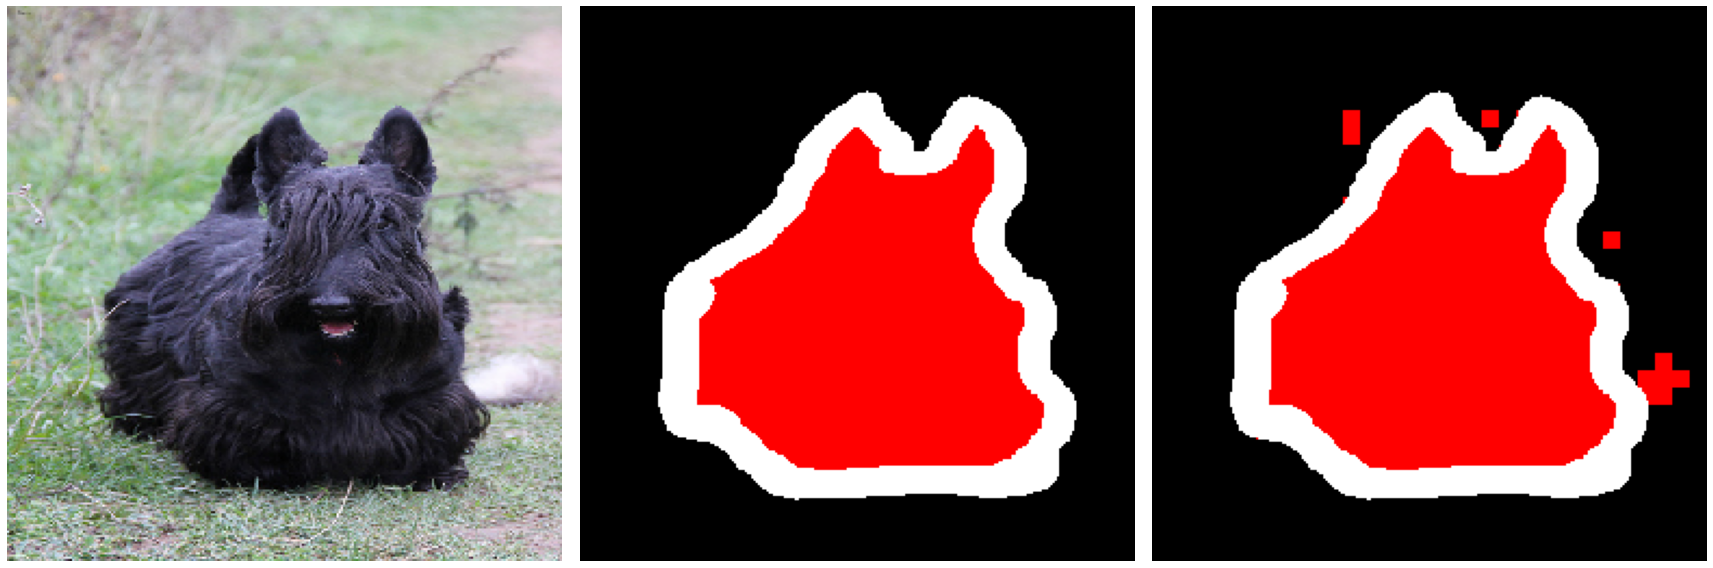

torch.Size([3669, 256, 256])


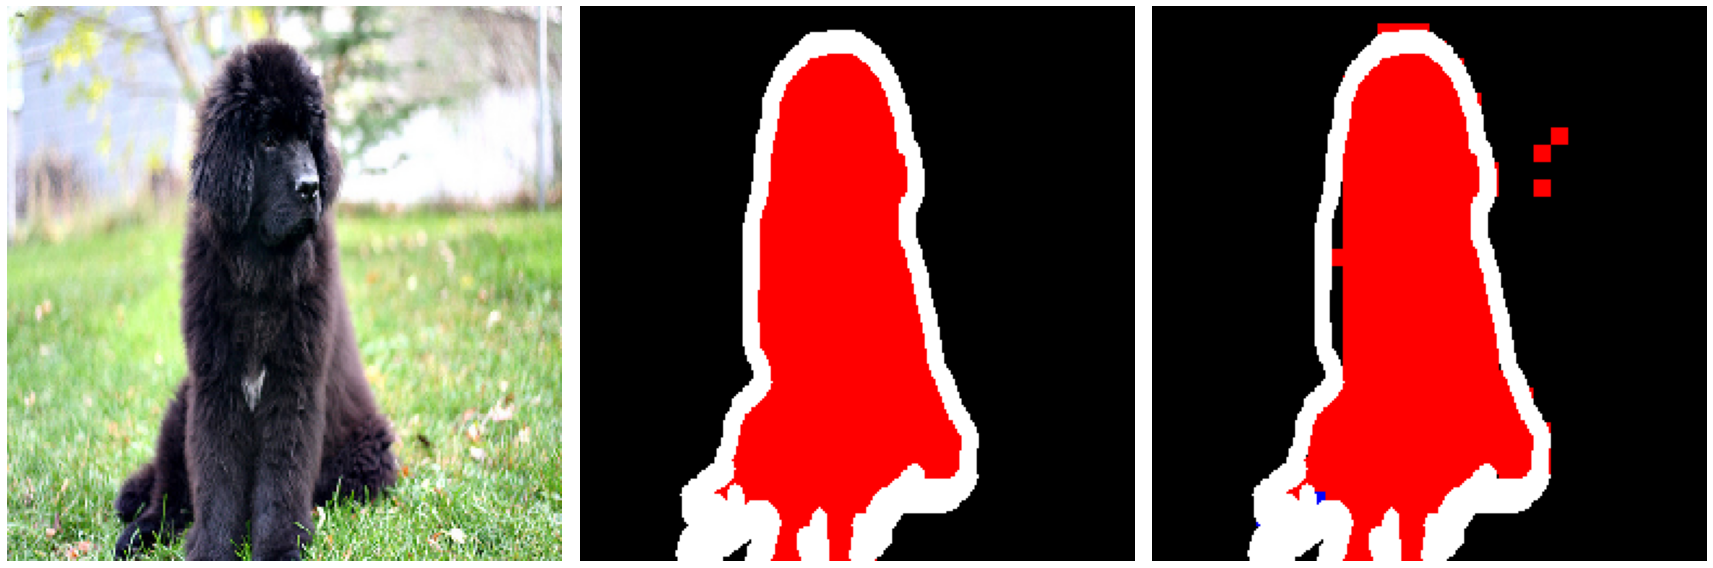

torch.Size([3669, 256, 256])


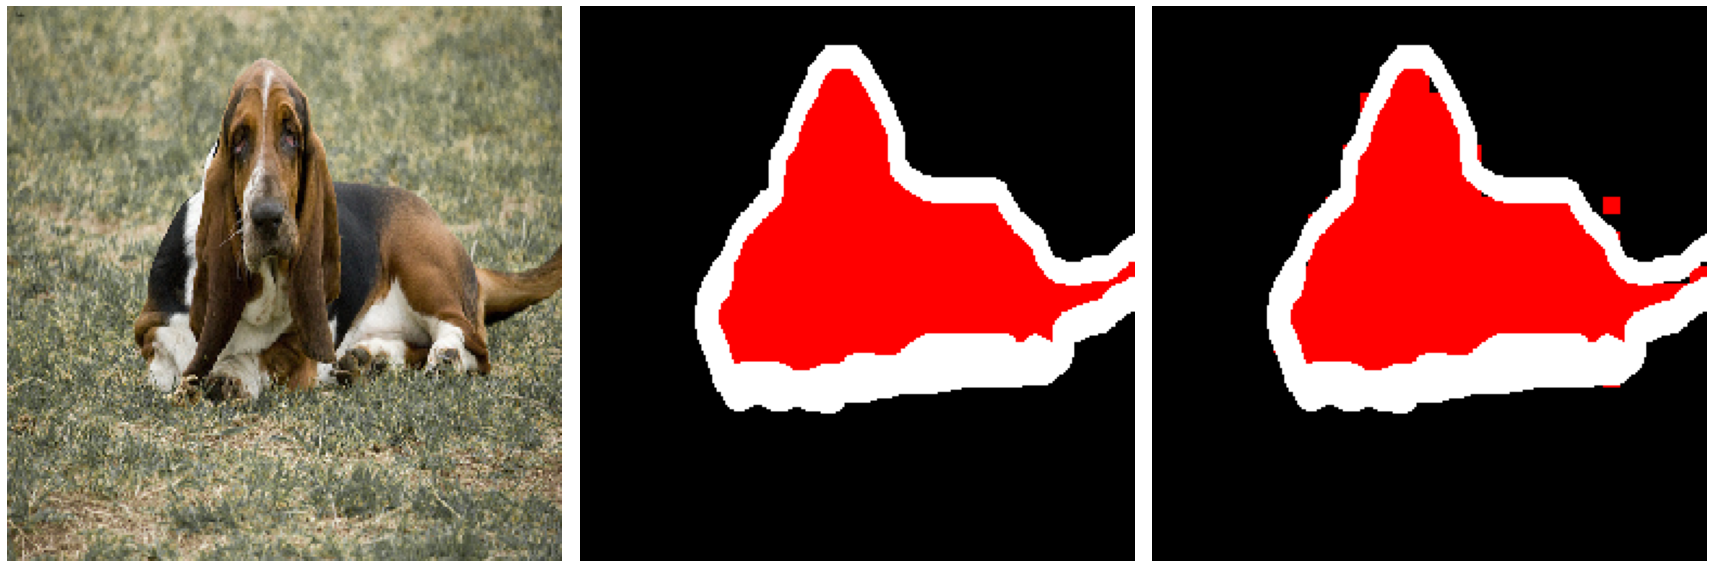

In [34]:
img_idx = np.random.randint(0, 100)
for idx, (input, target) in enumerate(test_data_segm):
    if (idx < img_idx):
        continue
    print(dl_prediction.shape)
    draw((input.squeeze(), target.squeeze()), t_dict, dl_prediction[idx])
    plt.pause(0.1)
    if (idx == img_idx+2):
        break

Ответьте на вопрос: `Как выбор функции потерь влияет на рассчитываемые метрики в ходе обучения?`

Ваш ответ: ...

### 3.3 Бонусное задание: Реализация и обучение двуглавой сети (3 балла)

До этого момента мы ни разу не использовали тот факт, что в нашем датасете не бывает слуаев, в которых и собака, и кошка одновременно находятся в кадре. В это же время блок `SegmentationHead` допускает этот случай, что дает теоретическую возможность модели ошибиться. Чтобы повысить устойчивость модели мы будем использовать две головы: `голова двухклассовой сегментации`, которая сегментирует животное на изображении, а вторая `голова бинарной классификации` будет предсказывать, что это за животное (собака или кошка). Таким образом, наша модель не имеет возможности отнести голову животного к классу "собака", а туловище к классу "кошка", что увеличивает ее устойчивость. Реализуйте двуглавый блок `SegmentationClassificationHeads`.

In [ ]:
class SegmentationClassificationHeads(nn.Module):
    def __init__(self, in_channels: int, num_classes: int, dropout: float = 0.1):
        """
        Вычисляет score для каждого из классов
        Вход: тензор (Batch_size, `in_channels`, Height, Width)
        
        Выход: тензор (Batch_size, `num_classes`, Height, Width)
        """
        super().__init__()
        self.segmentation_head = nn.Sequential(
            """
            ==== YOUR CODE =====
                 ¯\_(ツ)_/¯
            """
            nn.Conv2d(???, 2, kernel_size=1)
        )
        
        self.classification_head = nn.Sequential(
            """
            ==== YOUR CODE =====
                 ¯\_(ツ)_/¯
            """
            nn.Flatten(),
            nn.Linear(???, num_classes - 1),
            nn.Softmax(dim=1)
        )
        
    def combine_heads(self, seg_pred: torch.tensor, cls_pred: torch.tensor) -> torch.tensor:
        """
        ==== YOUR CODE =====
             ¯\_(ツ)_/¯
        """
        return

    def forward(self, x: torch.tensor, x_supp: torch.tensor) -> torch.tensor:
        """
        Вот мы и воспользовались ранее фиктивным аргументом `x_supp`
        """
        cls_pred = self.classification_head(x_supp)
        seg_pred = self.segmentation_head(x)
        return self.combine_heads(seg_pred, cls_pred)

Обучите двуглавую сеть и получите улучшение метрик относительно наилучшего результата предыдущего пункта:
- `Mean IoU metric` > 0.93
- `Mean Recall metric` > 0.96

К вашему решению требуется прикрепить логи tensorboard.

In [ ]:
train_config["writer"] = SummaryWriter(comment="TwoHead_CEloss") #TwoHead_Floss
train_config["save_model_path"] = <PATH>

net = PSPNet(pretrained_model, SegmentationClassificationHeads, num_classes=3, train_config=train_config).to(DEVICE)
print("#параметров в сети:", count_parameters(net))

In [ ]:
net.train_model(train_dataloader_<YOUR_FORMAT>, val_dataloader_<YOUR_FORMAT>)

Тестируем модель:

In [ ]:
net.load_state_dict(torch.load(<PATH>))
net.eval();

In [ ]:
dl_prediction, dl_target = net.test_model(test_dataloader)

In [ ]:
print("Mean IoU metric: ", metric_class.IoUMetric(dl_prediction, dl_target))
print("Mean Recall metric: ", metric_class.RecallMetric(dl_prediction, dl_target))

Примеры работы вами обученной двуглавой сети:

In [ ]:
img_idx = np.random.randint(0, 100)
for idx, (input, target) in enumerate(test_dataloader_hdf5):
    if (idx < img_idx):
        continue
    draw((input.squeeze(), target.squeeze()), t_dict, dl_prediction[idx])
    plt.pause(0.1)
    if (idx == img_idx+2):
        break